In [1]:
import glob
from collections import defaultdict

import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scripts import aesthetics

aesthetics.activate_paper_rcParams()

In [2]:
# efficient fishers tests
import pyranges
import statsmodels.stats.multitest

# CWAS Gene Set Enrichment

In this notebook, we explore whether categories significantly enriched for SVs in cases vs. controls reflect any higher level biological process. One way to do this is with gene set enrichment.

# What is gene set enrichment anyway?

The goal for this notebook is to try to ascribe some interpretability to these categories. One way to do that is to examine if these categories have relevant overlaps with gene sets, which might reflect some underlying biological process being impacted by SVs.

Gene set enrichment is a general problem, and the exact method of tackling it depends on the nature of the data and the problem. I'll walk through and describe my approach next.

## How do we calculate things?

There are two "methods" of gene set enrichment that I'd like to explore. Each is designed to answer a different question:

1. Enrichment of a gene set in a category relative to the background reference
2. Enrichment of a gene set _within a category_

The difference between these two is subtle but important, and it comes down to the category size. The largest categories (like protein coding genes for coding SVs) cannot have enrichment for gene sets--after all, there is no "background reference" that is not in the category!

The second approach fundamentally _controls for the pre-enrichment of a gene set in a category_. It will be significant when there is further SV enrichment beyond the pre-enrichment--put another way, when the "signal" is coming from a subset of the category that overlaps more with the gene set than other genes in the category.

### Tests we'll explore

__Pre-enrichment of categories__

This is a fisher's exact test that explores pure overlap between categories and gene sets. Our contingency table is as follows:

```
number of genes in cat and gs | number of genes in cat and not gs
number of genes in gs and not cat | number of genes not in cat and not in gs
```

This effectively examines the "pre-enrichment" of categories for gene sets and ignores the role of SVs. We've already examined this in pgsvs-extract-category-genes.

__Dosage-ignoring gene effects__

```
number of genes affected by SVs in cat and gs | number of genes affected by SVs in cat and not gs
number of genes affected by SVs in gs and not cat | number of genes affected by SVs not in cat and not in gs
```

This effectively subsets the above results to only those that are actually affected by SVs. This process ignores dosage beyond the first sample.

__Full count approach__

```
count of genes affected by SVs in cat and gs | count of genes affected by SVs in cat and not gs
count of genes affected by SVs in gs and not cat | count of genes affected by SVs not in cat and not gs
```

This is the "broadest" version of this question. It asks whether our observed SV counts in a category reflect enrichment of that gene set.

__Binomial test__

All of the above tests will "break" with large categories that complete contain gene sets (since there will be NO counts outside the category and inside the gene set, etc). The binomial test asks about gene set enrichment within a gene set. It asks "what is the probability of observing at least as many SVs in this gene set, assuming random selection from our gene list in the category?"

There are tons of confouding influences here we should _maybe_ consider, but for now I'll just run the binomial test.

# Load in the data

We load in the SVs and dosages, which we'll need.

## Read in SVs, metadata, dosages, and reference genes

In [3]:
# define SVs and dosages for discovery and validation
sv_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
dosages_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

gene_ref_path = "data/CWAS data for Jett/gencode_hg38_protein_coding_genes_for_annotation_7_31_23 (1).txt"

In [4]:
gene_ref = pd.read_csv(gene_ref_path)
gene_ref = gene_ref[~gene_ref["value"].str.startswith("ENSG00")]
gene_ref = sorted(set(gene_ref["value"].tolist()))
len(gene_ref)

19201

In [5]:
gene_lengths = pd.read_csv("data/cwas-results/gene-lengths.csv").set_index('gene_name')['length']

In [6]:
intergenic_sv_to_gene_distances = pd.read_csv('data/cwas-results/intergenic-sv-to-gene-distances.csv')

Load metadata and SVs

In [7]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
samples = defaultdict(dict)

total_samples = []
for disease in ["neuroblastoma", "ewing", "osteosarcoma"]:
    for cohort in ["case", "control"]:
        disease_cohort_samples = metadata[(metadata[f"{disease}_{cohort}"] == True)][
            "entity:sample_id"
        ].tolist()

        samples[disease][cohort] = disease_cohort_samples
        total_samples += disease_cohort_samples

        print(disease, cohort, len(disease_cohort_samples))

total_samples = sorted(set(total_samples))

neuroblastoma case 688
neuroblastoma control 4831
ewing case 775
ewing control 4574
osteosarcoma case 284
osteosarcoma control 4817


Now we load the SVs.

In [8]:
###############
##### SVs #####
###############
svs = pd.read_csv(sv_path, sep="\t", usecols=range(49))

###############
### Dosages ###
###############=

# we only need the dosages of our samples in question
dosage_head = pd.read_csv(dosages_path, sep="\t", index_col=False, nrows=1)

cols = [3] + [i for i, c in enumerate(dosage_head.columns) if c in total_samples]

dosages = pd.read_csv(dosages_path, sep="\t", index_col=False, usecols=cols)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,34,35,37,39,41,45,46,47,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
dosages = dosages.set_index("ID")

Add the intergenic distances, if relevant

In [10]:
svs = svs.merge(intergenic_sv_to_gene_distances[['name', 'distance']].rename(columns = {'distance': 'distance_to_nearest_gene'}), 
          on = 'name', how = 'left')

In [11]:
svs.shape

(228943, 50)

## Read in category genes

In [62]:
category_gene_matrix = pd.read_csv(
    "data/cwas-results/category-gene-matrix.csv"
).set_index("category")

In [63]:
category_gene_matrix.head(2)

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
category,,,,,,,,,,,,,,,,,,,,,
DEL.SINGLETON.ANY.unconstrained.expressed_in_adrenal_gland.protein_coding,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,1,0,0,0,1,1,0,0,1,0,...,1,1,1,0,0,0,0,1,0,0


In [64]:
gene_ref = list(category_gene_matrix.columns)

## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files.

In [12]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/CWAS data for Jett/List of variants by category/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding


In [13]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/CWAS data for Jett/CWAS sum stats/*.txt"):
    if "12_26_23" not in file:
        continue

    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"
    af_category = "singleton" if "SINGLETON" in file else "rare"

    data = pd.read_csv(file, sep="\t")
    data[["disease", "sv_category", "af_category"]] = [
        disease,
        sv_category,
        af_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)

In [32]:
row = svs[svs['name'] == 'PedSV.2.5.2_DEL_chr19_6025'].iloc[0]

In [33]:
row

#chrom                                                                        chr19
start                                                                      45317511
end                                                                        45319056
name                                                     PedSV.2.5.2_DEL_chr19_6025
svtype                                                                          DEL
AC                                                                                1
AF                                                                         0.000074
ALGORITHMS                                                                     wham
AN                                                                            13462
BOTHSIDES_SUPPORT                                                              True
CHR2                                                                            NaN
CNV_CONCORDANCE                                                             

In [14]:
framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,...,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,disease,sv_category,af_category
0,0.175033,0.771178,0.226968,0.820448,2,1,644,646,12,1,...,DEL.SINGLETON.ANY.missense_constrained.ANY.sig...,DEL,SINGLETON,0.003096,0.002554,0.002619,0.085949,neuroblastoma,coding,singleton
1,0.245302,0.150614,1.628679,0.103381,53,1,593,646,309,2,...,DEL.SINGLETON.ANY.unconstrained.expressed_in_a...,DEL,SINGLETON,0.082043,0.065759,0.067727,0.985559,neuroblastoma,coding,singleton


In [15]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):

    sv_category = "noncoding" if "noncoding" in file else "coding"
    suffix = file.split("/")[-1]
    if sv_category == "coding":
        disease = suffix.split('_')[2]
    else:
        disease = suffix.split('_')[3]

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

In [16]:
framework_schema["neuroblastoma"]["noncoding"]

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,neuroblastoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,neuroblastoma_chromHMM15_Enh,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,neuroblastoma_chromHMM15_Enh_conserved,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,neuroblastoma_chromHMM15_EnhG,PREDICTED_UTR,NaN,NaN,NaN
4,ANY,NaN,NaN,neuroblastoma_chromHMM15_EnhG_conserved,ANY,NaN,NaN,NaN
5,NaN,NaN,NaN,neuroblastoma_H3K27Ac_peak,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,neuroblastoma_chromHMM15_TssAFlnk,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,neuroblastoma_ABC_MAX_enhancer,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,neuroblastoma_atac_peaks_conserved,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,neuroblastoma_chromHMM15_EnhBiv,NaN,NaN,NaN,NaN


# Defining our reference gene counts

Here we define our "reference" counts for the two fisher approaches. See this contingency table:

```
count of genes affected by SVs in cat and gs | count of genes affected by SVs in cat and not gs
count of genes affected by SVs in gs and not cat | count of genes affected by SVs not in cat and not gs
```

This contingency table requires knowing `count of genes affected by SVs not in cat and not gs`, which means that effectively we need the gene counts across the genome.

The issue is that this depends on our specific question. Non-coding SV analyses shouldn't include coding SVs, since we're not interested in coding effects vs. non-coding effects. We're interested in subsetting to coding effects. 

In that case, we also need to define variables that change how we calculate this reference.

`coding vs. non-coding`  
`cases vs. controls vs. control_subtraction`  

I'm simply going to drop all SVs that have multiple gene effects. There aren't that many of them and dealing with an extra layer is super annoying.

I'm also going to drop all SVs that have only an intergenic effect that are ≥ 500 kb away from their gene.

## Adding an annotation for coding/non-coding/multi effects

Needed for filtering out multi SVs

In [17]:
# an svs is True for "multiple-genes-coding" if it affects more than one gene across all coding genic relationships.
# The same is true for multiple-genes-noncoding.
coding_cols = [
    "PREDICTED_LOF",
    "PREDICTED_PARTIAL_EXON_DUP",
    "PREDICTED_INTRAGENIC_EXON_DUP",
    "PREDICTED_COPY_GAIN",
]
noncoding_cols = [
    "PREDICTED_NEAREST_TSS",
    "PREDICTED_INTRONIC",
    "PREDICTED_PROMOTER",
    "PREDICTED_UTR",
]

for label, cols in zip(
    ["coding", "noncoding", "both"],
    [coding_cols, noncoding_cols, coding_cols + noncoding_cols],
):

    # we define all the genes that are "affected" by an SV. We
    # do this by looking at successive genic relationships
    affected_genes = np.array(svs[cols[0]].fillna("").str.split(","))
    for c in cols[1:]:
        affected_genes += np.array(svs[c].fillna("").str.split(","))

    # remove blanks and duplicate genes
    affected_genes = [[g for g in set(g_list) if g != ""] for g_list in affected_genes]
    affected_genes_col = [",".join(g_list) for g_list in affected_genes]

    # extract out how many unique genes are affected by each SV
    num_unique_affected_genes = [len(set(g_list)) for g_list in affected_genes]
    multiple_genes = np.array(num_unique_affected_genes) > 1

    # add a column to our SVs
    svs[f"num_genes_{label}"] = num_unique_affected_genes
    svs[f"genes_{label}"] = affected_genes_col

In [19]:
multigene_svs = svs.query("num_genes_both > 10")["name"].tolist()

svs.shape, len(multigene_svs)

((228943, 56), 64)

We drop these SVs.

In [20]:
svs = svs.query("num_genes_both <= 10").copy()
category_svs = category_svs[~(category_svs["SV"].isin(multigene_svs))].copy()

## Drop intergenic SVs that are far from their gene

We only drop an SV in this manner if it's the only way it affects a gene.

In [21]:
only_intergenic_svs = svs[(svs['PREDICTED_NEAREST_TSS'] == svs['genes_both']) & (svs['num_genes_coding'] == 0)].copy()
dropped_intergenic_svs = only_intergenic_svs.query('distance_to_nearest_gene > 5e5')['name'].tolist()

In [22]:
svs.shape

(228879, 56)

In [23]:
svs = svs[~(svs['name'].isin(dropped_intergenic_svs))]

In [24]:
svs.shape

(206749, 56)

## Drop those SVs in pesky reference areas

These can actually have a substantial effect downstream if not handled now.

__Note:__ Not including this filter for now.

In [25]:
print(svs['HG38_REF_PATCH_LOCUS'].mean())

0.021838074186574057


In [26]:
# svs = svs.query('HG38_REF_PATCH_LOCUS == False')

## Actually create references

These references will also serve as the lookup point for our actual categories. That way, we don't have to recalculate counts, etc.

In [27]:
row_idx = 0
row_names = []

# identify rare SVs first
rare_svs = svs[svs["AF"] < 0.01].copy().set_index("name")

# check that all our category SVs are here
# assert len(set(category_svs["SV"]) - set(rare_svs.index) - set(dropped_intergenic_svs)) == 0

ref_counts = []
for disease in ["neuroblastoma", "ewing", "osteosarcoma"]:

    sub_reference = rare_svs.copy()
    disease_samples = samples[disease]

    # identify SVs that affect genes in coding or non-coding fashion
    for sv_category in ["coding", "noncoding"]:
        sub_reference = rare_svs[rare_svs[f"num_genes_{sv_category}"] > 0]

        # check that our category SVs are all represented
        category_sub_svs = category_svs[
            (category_svs["disease"] == disease)
            & (category_svs["sv_category"] == sv_category)
        ].copy()

        # it's ok to not have category SVs that have no associated genes
        missing_svs = set(category_sub_svs["SV"]) - set(sub_reference.index) - set(dropped_intergenic_svs)

        # assert rare_svs.loc[missing_svs, f"num_genes_{sv_category}"].sum() == 0

        # now we can build our reference gene counts
        gene_counts = {}
        for cohort in ["case", "control"]:

            # subset dosages to our reference svs and cohort samples
            cohort_samples = disease_samples[cohort]
            sub_dosages = dosages.loc[sub_reference.index, cohort_samples]

            # drop samples with bad genotyping and fill in na's as 0 (effectively ignored)
            kept_samples = np.where(
                pd.isnull(sub_dosages).sum(axis=0) / len(sub_dosages) < 0.05
            )[0]
            sub_dosages = sub_dosages.iloc[:, kept_samples].fillna(0).astype(int)

            # finally, we create the gene list with counts. First get the SVs based on gene counts
            sv_genes = sub_reference[f"genes_{sv_category}"]
            sv_genes = sv_genes.str.split(',').explode()

            sv_names = sv_genes.index
            sv_counts = sub_dosages.loc[sv_names].sum(axis=1)

            subreference_counts = pd.DataFrame(
                [sv_names, sv_counts, sv_genes], index=["name", "dose", "gene"]
            ).T

            # remove genes not in our reference (shouldn't happen, but just in case)
            subreference_counts = subreference_counts[
                subreference_counts["gene"].isin(gene_ref)
            ]

            # store
            gene_counts[cohort] = subreference_counts

        control_genes = set(gene_counts["control"].query("dose > 0")["gene"])
        case_unique = gene_counts["case"][
            lambda row: ~row["gene"].isin(control_genes)
        ].copy()
        gene_counts["case_unique"] = case_unique

        # add all to reference counts
        for cohort in ["case", "control", "case_unique"]:
            cohort_data = gene_counts[cohort]
            cohort_data["disease"] = disease
            cohort_data["sv_category"] = sv_category
            cohort_data["cohort"] = cohort

            ref_counts.append(cohort_data)

        print(disease, sv_category)

ref_counts = pd.concat(ref_counts)

neuroblastoma coding
neuroblastoma noncoding
ewing coding
ewing noncoding
osteosarcoma coding
osteosarcoma noncoding


Excellent - so now we have a way to look up the SVs in a category and their associated gene counts.

## A quick check

I'd like to ensure that--for the most part--our category SVs are truly restricted to our category eligible genes.

In [ ]:
# just do this for our significant categories
overlaps = []
for index, row in framework_results.query("negative_log10_p_value > 3").iterrows():
    category, disease, sv_category = row[["category_name", "disease", "sv_category"]]

    category_genes = category_gene_matrix.loc[category]
    category_genes = list(category_genes[category_genes == 1].index)

    sub_category_svs = category_svs[
        (category_svs["category"] == category) & (category_svs["disease"] == disease)
    ]["SV"].tolist()

    category_counts = ref_counts[
        (ref_counts["name"].isin(sub_category_svs))
        & (ref_counts["disease"] == disease)
        & (ref_counts["sv_category"] == sv_category)
    ]

    # give me the percentage of category count genes in the eligible genes
    o = len(set(category_counts["gene"]) & set(category_genes))
    o_denom = len(set(category_counts["gene"]))
    overlaps.append([category, disease, sv_category, o, o / o_denom])

overlaps = pd.DataFrame(
    overlaps,
    columns=[
        "category",
        "disease",
        "sv_category",
        "overlap",
        "perc_category_counts_in_eligible",
    ],
)
overlaps = overlaps.sort_values(by="perc_category_counts_in_eligible")

In [ ]:
overlaps.head(8)

Interesting--there are categories for which are overlap isn't so great. Unsurprisingly, they're all noncoding categories. I think 80% shouldn't abolish relevant signal.

# Shrink down our data

We subset some of our data to prevent working with massive matrices.

In [ ]:
# shrink down our categories to only those that are significant
framework_results = framework_results.query('negative_log10_p_value > 3.0').reset_index(drop = True)

# subset our SVs to these categories. Have to be careful about disease, since category names can repeat.
included_disease_categories = (framework_results['disease'] + '-' + framework_results['category_name']).tolist()
5
# subset down category svs to these categories
category_svs = category_svs[(category_svs['disease'] + '-' + category_svs['category']).isin(included_disease_categories)].reset_index(drop = True)

# drop SVs down to these SVs
svs = svs[svs['name'].isin(set(category_svs['SV']))]

# shrink dosages down to our nbl samples and these SVs
dosages = dosages.loc[svs['name'].tolist(), total_samples]

# shrink down category lookups
category_gene_matrix = category_gene_matrix.loc[sorted(set(framework_results['category_name']))]

In [44]:
category_gene_matrix.shape, dosages.shape, svs.shape

((17454, 19092), (228943, 6727), (206749, 56))

# A coding example

Let's extract out all the data that we need to examine the highest result for a single hallmark gene set. To be informative, we'll use a coding category that has a restricted gene space: `ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding`

We'll generate data for our two contingency tables. Note that we extract out the eligible genes here as well.

In [39]:
test_cat = "ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding"

In [40]:
framework_schema["neuroblastoma"]["coding"].head(5)

,sv_type,frequency,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_COPY_GAIN,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_INTRAGENIC_EXON_DUP,missense_constrained,ANY,cosmic_cancer_genes
2,CPX_or_INV,NaN,PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP,unconstrained,NaN,germline_CPGs
3,INS_ALL,NaN,ANY,ANY,NaN,base_excision_repair_genes
4,ANY,NaN,NaN,NaN,NaN,chromatin_organization_genes


We identify the SVs that are part of that category. Same code as above.

In [41]:
test_cat_svs = category_svs[
    (category_svs["category"] == test_cat)
    & (category_svs["disease"] == "neuroblastoma")
]["SV"].tolist()

test_cat_counts = ref_counts[
    (ref_counts["name"].isin(test_cat_svs))
    & (ref_counts["disease"] == "neuroblastoma")
    & (ref_counts["sv_category"] == "coding")
    & (ref_counts["dose"] > 0)
]

test_cat_counts.shape, len(test_cat_svs)

((2598, 6), 2236)

This includes all cohorts. Now let's pull up a hallmark gene set and get cracking.

In [42]:
hallmark = gp.get_library(name="MSigDB_Hallmark_2020")

In [43]:
adipogenesis = hallmark["Adipogenesis"]
adipogenesis = [g for g in adipogenesis if g in gene_ref]
len(adipogenesis)

200

## Simple gene count overlap

Here, we ignore the gene counts and simply overlap with the _entire_ reference counts.

```
number of genes affected by SVs in cat and gs | number of genes affected by SVs in cat and not gs
number of genes affected by SVs in gs and not cat | number of genes affected by SVs not in cat and not in gs
```

To do this, we need to extract our references for this specific analysis.

In [44]:
# reference has to be defined for cases, controls, and case_unique
reference_counts_example = {}

for cohort in ["case", "control", "case_unique"]:

    # exclude category SVs
    ref_cohort_counts = ref_counts[
        (~ref_counts["name"].isin(test_cat_svs))
        & (ref_counts["disease"] == "neuroblastoma")
        & (ref_counts["sv_category"] == "coding")
        & (ref_counts["cohort"] == cohort)
        & (ref_counts["dose"] > 0)
    ]

    reference_counts_example[cohort] = ref_cohort_counts
    print(cohort, len(ref_cohort_counts))

case 1727
control 5452
case_unique 329


Run the enrichment.

In [45]:
for cohort in ["case", "control", "case_unique"]:

    cohort_genes = test_cat_counts[test_cat_counts["cohort"] == cohort]["gene"]
    cohort_reference_genes = reference_counts_example[cohort]["gene"]

    num_genes_in_cat_and_gs = len(set(adipogenesis) & set(cohort_genes))
    num_genes_in_cat_and_not_gs = len(set(cohort_genes) - set(adipogenesis))

    num_genes_in_gs_and_not_cat = len(set(adipogenesis) & set(cohort_reference_genes))
    num_genes_not_in_gs_and_not_cat = len(
        set(cohort_reference_genes) - set(adipogenesis)
    )

    cont_table = np.array(
        [
            [num_genes_in_cat_and_gs, num_genes_in_cat_and_not_gs],
            [num_genes_in_gs_and_not_cat, num_genes_not_in_gs_and_not_cat],
        ]
    )
    print(scipy.stats.fisher_exact(cont_table))

(3.013387792148854, 0.015438673967258142)
(1.7901296111665006, 0.02930297620171999)
(1.7140600315955765, 0.3963764685975137)


That is SUPER interesting. The controls are very strongly enriched. But remember that this carries the category pre-enrichment. So we actually EXPECT controls to be significant. This means that case_unique is a useless filtering method.

## Full count approach

What if we actually include SV dosage? Here, we DON'T use the binary form of this matrix.

In [46]:
for cohort in ["case", "control", "case_unique"]:

    cohort_genes = test_cat_counts[test_cat_counts["cohort"] == cohort]
    cohort_reference_genes = reference_counts_example[cohort]

    num_gene_counts_in_cat_and_gs = cohort_genes[
        cohort_genes["gene"].isin(adipogenesis)
    ]["dose"].sum()
    num_gene_counts_in_cat_and_not_gs = cohort_genes[
        ~cohort_genes["gene"].isin(adipogenesis)
    ]["dose"].sum()

    num_gene_counts_in_gs_and_not_cat = cohort_reference_genes[
        cohort_reference_genes["gene"].isin(adipogenesis)
    ]["dose"].sum()
    num_gene_counts_not_in_gs_and_not_cat = cohort_reference_genes[
        ~cohort_reference_genes["gene"].isin(adipogenesis)
    ]["dose"].sum()

    cont_table = np.array(
        [
            [num_gene_counts_in_cat_and_gs, num_gene_counts_in_cat_and_not_gs],
            [num_gene_counts_in_gs_and_not_cat, num_gene_counts_not_in_gs_and_not_cat],
        ]
    )
    print(scipy.stats.fisher_exact(cont_table))

(3.398674242424242, 0.0024051803380642305)
(2.975911791581829, 6.800433268464122e-07)
(1.428348909657321, 0.597479440925016)


Same deal

## Binomial test approach

Here, we examine _within the category_. We need the eligible category genes.

In [65]:
example_category_genes = category_gene_matrix.loc[test_cat]
example_category_genes = list(example_category_genes[example_category_genes == 1].index)

len(example_category_genes)

9505

In [66]:
cat_gene_lengths = gene_lengths.loc[example_category_genes]

We'll also normalize by gene size

In [67]:
gs_genes_in_cat = set(adipogenesis) & set(example_category_genes)

for cohort in ["case", "control", "case_unique"]:

    cohort_gene_counts = test_cat_counts[test_cat_counts["cohort"] == cohort]

    count_genes_in_cat_and_gs = cohort_gene_counts[
        cohort_gene_counts["gene"].isin(adipogenesis)
    ]["dose"].sum()
    total_counts = cohort_gene_counts["dose"].sum()

    # we compare this to the odds of randomly drawing at least as many SVs in the gs within this category
    gs_genes_in_cat = set(adipogenesis) & set(example_category_genes)
    null_p = cat_gene_lengths.loc[gs_genes_in_cat].sum() / cat_gene_lengths.sum()

    res = scipy.stats.binomtest(count_genes_in_cat_and_gs, total_counts, null_p)
    print(res, count_genes_in_cat_and_gs, total_counts, null_p)

BinomTestResult(k=10, n=362, alternative='two-sided', proportion_estimate=0.027624309392265192, pvalue=0.1464225338984107) 10 362 0.01693989492662021
BinomTestResult(k=32, n=2015, alternative='two-sided', proportion_estimate=0.01588089330024814, pvalue=0.7955616049495297) 32 2015 0.01693989492662021
BinomTestResult(k=7, n=221, alternative='two-sided', proportion_estimate=0.03167420814479638, pvalue=0.10688559733003276) 7 221 0.01693989492662021


Nice! So this is exactly what we're looking for.

# Generalized gene set enrichment

Alright, we've been through our examples. Time to crunch them all.


## Define the categories for analysis

We analyze only the significant categories

Here, we'll also define a helpful lookup that maps from the "collapsed" genic relationships to all their component relationships.

In [68]:
gr_coding_mapping = {
    "PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP": [
        "PREDICTED_LOF",
        "PREDICTED_PARTIAL_EXON_DUP",
    ],
    "ANY": [
        "PREDICTED_COPY_GAIN",
        "PREDICTED_INTRAGENIC_EXON_DUP",
        "PREDICTED_LOF",
        "PREDICTED_PARTIAL_EXON_DUP",
    ],
}

gr_noncoding_mapping = {
    "ANY": [
        "PREDICTED_INTERGENIC",
        "PREDICTED_INTRONIC",
        "PREDICTED_PROMOTER",
        "PREDICTED_UTR",
    ]
}

## Define the gene sets for analysis

Let's highlight some specific gene sets for analysis. We'll do the following:

* `MSigDB_Hallmark_2020`
* `GO_Biological_Process_2023` (this is the default for GO term analysis)
* `Reactome_2022`

We only include gene sets that are at least 10 genes, and at maximum 1000.

We'll begin with these, and then we can add in other specific ones that might be relevant later:

## Define some adrenal gene sets

I'm curious about these:

In [69]:
# obtained by searching "adrenal gland" on go
adrenal_gs = pd.read_csv('data/adrenal-gene-sets.txt', sep = '\t', header = None, names = ['go', 'gs'])
adrenal_gs = list(adrenal_gs['gs'] + ' (' + adrenal_gs['go'] + ')')

In [70]:
gene_sets = {}
dbs = set()
with open("ref/gene-sets.txt") as gs_in:
    for line in gs_in:
        comp = line.strip().split("\t")
        db = comp[0]
        dbs.add(db)
        gs = comp[1]
        genes = comp[2:]
        
        if db in ['Reactome_2022', 'GO_Biological_Process_Specific']:
            continue
            
        if gs in adrenal_gs:
            gene_sets[f'adrenal | {gs}'] = genes
        
        elif len(genes) >= 30 and len(genes) <= 1000:
            gene_sets[db + " | " + gs] = genes

How large are the adrenal gene sets?

In [71]:
print([len(genes) for gs, genes in gene_sets.items() if 'adrenal' in gs])

[8, 2, 1, 6, 3, 1, 20, 16, 2, 7, 152, 9, 22, 5, 2, 1, 3, 3, 1, 1, 3, 14, 30, 1, 9, 2, 28, 6, 2, 2, 62, 2, 2, 6, 5, 2, 6, 4, 3, 14, 3, 3, 11, 5, 5, 2, 30]


Much too small for us to detect anything. We'll include them anyway.

Add some gene sets defined in our `gtex` analysis

In [72]:
with open('data/gtex-tissue-specific-gene-sets.txt') as infile:
    for line in infile.readlines():
        line = line.strip()
        tissue = line.split(' | ')[0].lower()
        genes = line.split(' | ')[1].split(',')
        
        gene_sets[f'gtex | {tissue}'] = genes

In [73]:
print(len(gene_sets))

3137


I want to briefly explore controlling for gene size

In [74]:
test_genes = gene_sets['GO_Biological_Process_Full | ribosome biogenesis (GO:0042254)']
test_category = 'ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding'

cat_genes = list(category_gene_matrix.loc[test_category][category_gene_matrix.loc[test_category] == 1].index)
overlapping_genes = set(test_genes) & set(cat_genes)

null_p_gene = len(set(test_genes) & set(cat_genes)) / len(cat_genes)

test_gene_size = gene_lengths.loc[overlapping_genes].sum()
cat_gene_size = gene_lengths.loc[cat_genes].sum()
null_p_size = test_gene_size / cat_gene_size

print(null_p_gene, null_p_size)

0.015254586683158112 0.010909559605254067


So it can indeed make a fairly impactful difference.

## Create gene set and category matrices

It's far easier to work with this in matrix form, so we convert it as such.

In [75]:
cat_gene_sparse_mtx = scipy.sparse.csr_matrix(category_gene_matrix.values)

# lookups for sparse matrix work
gene_to_idx = {gene: i for i, gene in enumerate(category_gene_matrix.columns)}
cat_to_idx = {cat: i for i, cat in enumerate(category_gene_matrix.index)}

In [76]:
# and now convert the gene sets to a sparse matrix
gs_to_idx = {}

values = []
row_indices = []
column_indices = []
for i, (gs, genes) in enumerate(gene_sets.items()):
    gs_to_idx[gs] = i

    column_indices += [gene_to_idx[g] for g in genes]
    row_indices += [i] * len(genes)
    values += [1] * len(genes)

values = np.array(values)
row_indices = np.array(row_indices)
column_indices = np.array(column_indices)

gs_gene_sparse_mtx = scipy.sparse.csr_matrix(
    (values, (row_indices, column_indices)), shape=(len(gs_to_idx), len(gene_to_idx))
).T

In [77]:
category_gene_matrix.shape, gs_gene_sparse_mtx.shape

((17454, 19092), (19092, 3137))

In [78]:
gs_gene_matrix = pd.DataFrame(gs_gene_sparse_mtx.todense().A, index = gene_to_idx.keys(), columns = gs_to_idx.keys())

In [79]:
gs_gene_sparse_mtx

<19092x3137 sparse matrix of type '<class 'numpy.int64'>'
	with 488396 stored elements in Compressed Sparse Column format>

If we want to do our nice matrix math, we need to actually make a copy of this matrix that includes gene sizes (oops)

In [80]:
gene_lengths_ordered = gene_lengths.loc[list(gene_to_idx.keys())].values

In [81]:
gs_to_test = ['GO_Biological_Process_Full | central nervous system development (GO:0007417)',
              'GO_Biological_Process_Full | positive regulation of synaptic transmission (GO:0050806)',
              'GO_Biological_Process_Full | regulation of protein depolymerization (GO:1901879)',
              'GO_Biological_Process_Full | actin cytoskeleton organization (GO:0030036)']

for gs in gs_to_test:
    genes = gene_sets[gs]
    gs_gene_lengths = gene_lengths.loc[genes]
    
    nongs_genes = set(gene_lengths.index) - set(genes)
    nongs_gene_lengths = gene_lengths.loc[nongs_genes]
    
    print(gs, gs_gene_lengths.mean(), nongs_gene_lengths.mean())

GO_Biological_Process_Full | central nervous system development (GO:0007417) 119192.53799392097 66509.43783485224
GO_Biological_Process_Full | positive regulation of synaptic transmission (GO:0050806) 146397.98571428572 68662.9743035036
GO_Biological_Process_Full | regulation of protein depolymerization (GO:1901879) 115420.16091954023 69021.56553538542
GO_Biological_Process_Full | actin cytoskeleton organization (GO:0030036) 101698.19288389513 68298.82379566763


In [82]:
gs_gene_lengths_sparse_mtx = scipy.sparse.csr_matrix(gs_gene_sparse_mtx.todense().A * gene_lengths_ordered[:, np.newaxis])

## A side note on picking gene sets

This process is a bit frustrating because gene sets can be so similar to each other. Let's try to use a similar process as the categories to crunch things down > eigenvalue decomposition.

I'm also going to only include GO terms here, because that's what we'll use downstream.

In [83]:
go_term_idx = [idx for gs, idx in gs_to_idx.items() if 'GO_Biological_Process_Full' in gs]

go_gs_gene_mtx = gs_gene_sparse_mtx[:, go_term_idx]

In [84]:
len(go_term_idx)

2722

In [85]:
numerator = go_gs_gene_mtx.T.dot(go_gs_gene_mtx)
gs_counts = go_gs_gene_mtx.sum(axis = 0)
denominator = gs_counts + gs_counts.T - numerator
jaccard_matrix = (numerator / denominator).A

In [86]:
eigenvalues = np.linalg.eigvals(jaccard_matrix)
eigenvalues_real = np.real(eigenvalues)
total_var = eigenvalues_real.sum()
var_explained = np.cumsum(eigenvalues_real) / total_var

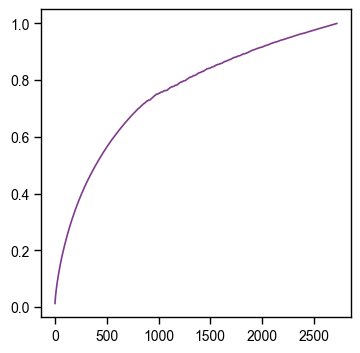

In [87]:
plt.plot(var_explained)

In [92]:
num_effective_tests = list(var_explained > 0.95).index(True)
num_effective_tests

2261

## Run the thing

This code will need to be decently adaptable, since it has to handle a few different unique components (noncoding categories, etc) and analyses. We're going to store _many_ different components, so let's list them all out here. For each gene set and category, we need to do the following:

* case vs. control vs. case_unique for cohort
* `dosage-ignore` vs. `full-counts` vs. `binomial` for our testing.


This is a TON of data, so hopefully the vectorized fishers exact makes it palatable. With that said, let's do it!

In [77]:
# reduce our framework results to only those we care about analyzing
analyzed_framework_results = framework_results.query('negative_log10_p_value > 3')

In [78]:
analyzed_framework_results['disease'].value_counts()

neuroblastoma    151
osteosarcoma      27
ewing             13
Name: disease, dtype: int64

Because it's relevant for gene set figure making later, I'm going to add a few more categories here:

In [79]:
added_categories = ['ANY.RARE.ANY.ANY.ANY.protein_coding', 'DEL.RARE.ANY.ANY.ANY.protein_coding']

added_categories = framework_results[(framework_results['disease'] == "neuroblastoma") &
                                     (framework_results['category_name'].isin(added_categories))]

In [80]:
analyzed_framework_results = pd.concat([analyzed_framework_results, added_categories])

In [81]:
len(analyzed_framework_results)

193

In [85]:
fisher_results = []
binomial_results = []

for i, (index, row) in enumerate(analyzed_framework_results.iterrows()):
    
    #######################################
    ### STEP 1 - DEFINE OUR GENE COUNTS ###
    #######################################
    
    # This process is the exact same for all categories - later steps will subset our gene counts
    print(i, end = ', ')
    cat_name = row['category_name']
    sv_category = row['sv_category']
    disease = row['disease']
    
    # next, we pull out our SVs in this category
    svs_in_category = category_svs[(category_svs["category"] == cat_name) &
                                   (category_svs["disease"] == disease)]['SV'].tolist()
    
    ###############################
    ### EXTRACT CATEGORY COUNTS ###
    ###############################
    category_counts = ref_counts[
        (ref_counts["name"].isin(svs_in_category))
        & (ref_counts["disease"] == disease)
        & (ref_counts["sv_category"] == sv_category)
        & (ref_counts["dose"] > 0)
    ]
    
    ###############################
    ### DEFINE REFERENCE COUNTS ###
    ###############################
    ref_category_counts = ref_counts[
        (~ref_counts["name"].isin(svs_in_category))
        & (ref_counts["disease"] == disease)
        & (ref_counts["sv_category"] == sv_category)
        & (ref_counts["dose"] > 0)
    ]
    
    ##################################################
    ### PRECALCULATE SOME VALUES FOR BINOMIAL TEST ###
    ##################################################
    
    # theoretically, we could include covariates like gene size, etc
    # we don't for now
    
    eligible_category_genes = category_gene_matrix.loc[cat_name].values
        
    gs_genes_in_cat = gs_gene_sparse_mtx.T.multiply(eligible_category_genes).sum(axis = 1).A1
    num_genes_in_cat = eligible_category_genes.sum()

    null_p_gs = (gs_genes_in_cat / num_genes_in_cat)
    
#     elif sv_category == 'coding':
        
#         gs_genes_in_cat_size = gs_gene_lengths_sparse_mtx.T.multiply(eligible_category_genes).sum(axis = 1).A1
#         total_cat_size = (gene_lengths_ordered * eligible_category_genes).sum()
        
#         null_p_gs = (gs_genes_in_cat_size / total_cat_size)
    
    ##############################
    ### RUN ANALYSES BY COHORT ###
    ###############################
        
    for cohort in ['case', 'control', 'case_unique']:
        
        cohort_category_counts = category_counts[category_counts['cohort'] == cohort]
        cohort_ref_category_counts = ref_category_counts[ref_category_counts['cohort'] == cohort]
        
        # transform gene counts into arrays
        cohort_gene_counts = cohort_category_counts.groupby(['gene'])['dose'].sum()
        cohort_ref_gene_counts = cohort_ref_category_counts.groupby(['gene'])['dose'].sum()
        
        # fill in missing gene counts (with 0)
        cohort_gene_counts = cohort_gene_counts.reindex(gene_ref, fill_value = 0).values.reshape(1, -1).astype(int)
        cohort_ref_gene_counts = cohort_ref_gene_counts.reindex(gene_ref, fill_value = 0).values.reshape(1, -1).astype(int)
        
        # we run two fishers - binary and not
        for analysis in ['full']:
            analysis_gene_counts = cohort_gene_counts.copy()
            analysis_ref_gene_counts = cohort_ref_gene_counts.copy()
            
            # if analysis == 'binary':
            #     analysis_gene_counts = analysis_gene_counts.astype(bool).astype(int)
            #     analysis_ref_gene_counts = analysis_ref_gene_counts.astype(bool).astype(int)
                
            # convert to sparse
            analysis_gene_counts = scipy.sparse.csr_matrix(analysis_gene_counts)
            analysis_ref_gene_counts = scipy.sparse.csr_matrix(analysis_ref_gene_counts)
            
            # build our contingency table
            cat_and_gs = analysis_gene_counts.dot(gs_gene_sparse_mtx)
            cat_and_not_gs = analysis_gene_counts.sum(axis = 1) - cat_and_gs
            not_cat_and_gs = analysis_ref_gene_counts.dot(gs_gene_sparse_mtx)
            not_cat_and_not_gs = analysis_ref_gene_counts.sum(axis = 1) - not_cat_and_gs

            # contingency table
            tp = cat_and_gs.todense().A1.astype(int)
            fp = cat_and_not_gs.A1.astype(int)
            fn = not_cat_and_gs.todense().A1.astype(int)
            tn = not_cat_and_not_gs.A1.astype(int)

            # calculate p values
            results = pyranges.statistics.fisher_exact(tp, fp, fn, tn, pseudocount = 1)
                
            results['ref_freq'] = pd.Series(fn.astype(str)) + '/' + pd.Series((fn + tn).astype(str))
            results['cat_freq'] = pd.Series((tp).astype(str)) + '/' + pd.Series((tp + fp).astype(str))
            results['db'] = [string.split(' | ')[0] for string in gene_sets]
            results['gs'] = [string.split(' | ')[1] for string in gene_sets]
            results['category'] = cat_name
            results['cohort'] = cohort
            results['analysis'] = analysis
            results['sv_category'] = sv_category
            results['disease'] = disease
            
            # add in a feature for unique number of genes in the overlap
            unique_gene_overlaps = analysis_gene_counts.astype(bool).multiply(gs_gene_sparse_mtx.T.astype(bool))
            unique_gene_overlaps = unique_gene_overlaps.todense().A.sum(axis = 1)
            results['num_unique_genes_in_overlap'] = unique_gene_overlaps
                
            results = results[['disease', 'category', 'sv_category', 'cohort', 'analysis', 'db', 'gs', 
                               'ref_freq', 'cat_freq', 'num_unique_genes_in_overlap', 'OR', 'P']]
            results = results.rename(columns = {'OR': 'odds_ratio', 'P': 'p'})

            # here, we do FDR correction. We ignore cases where there is no gene set overlap with the reference.
            fdr_p = statsmodels.stats.multitest.multipletests(results['p'].to_list(), method='fdr_bh')[1]
            results['fdr_p'] = fdr_p
            results['bonf_p'] = results['p'] * num_effective_tests

            fisher_results.append(results)
          
        #####################
        ### BINOMIAL TEST ###
        #####################
        
        # we've already calculated "successes" and counts above.
        # unfortunately this doesn't allow vectorization, and it's
        # mega slow
        binomial_test = [scipy.stats.binomtest(k, n, null_p) if n != 0 else np.nan for k, n, null_p in zip(tp, tp + fp, null_p_gs)]
        
        # transform to dataframe
        binomial_test = [(res.pvalue, res.proportion_estimate) if not pd.isnull(res) else (np.nan, np.nan) for res in binomial_test]
        binomial_test = pd.DataFrame(binomial_test, columns = ['p', 'observed_prop'])
        binomial_test['expected_prop'] = null_p_gs
        binomial_test['db'] = [string.split(' | ')[0] for string in gene_sets]
        binomial_test['gs'] = [string.split(' | ')[1] for string in gene_sets]
        binomial_test['category'] = cat_name
        binomial_test['cohort'] = cohort
        binomial_test['sv_category'] = sv_category
        binomial_test['disease'] = disease
        
        binomial_test = binomial_test[['disease', 'category', 'sv_category', 'cohort', 'db', 'gs', 
                                       'expected_prop', 'observed_prop', 'p']]
        
        fdr_p = statsmodels.stats.multitest.multipletests(binomial_test['p'].to_list(), method='fdr_bh')[1]
        binomial_test['fdr_p'] = fdr_p
        binomial_test['bonf_p'] = binomial_test['p'] * num_effective_tests
            
        # the binomial test uses the case unique counts, so we can reuse this variable (last of loop above)
        binomial_test['num_unique_genes_in_overlap'] = unique_gene_overlaps

        binomial_results.append(binomial_test)
                
gse_results = pd.concat(fisher_results)
binomial_results = pd.concat(binomial_results)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 

In [86]:
gse_results.head(2)

,disease,category,sv_category,cohort,analysis,db,gs,ref_freq,cat_freq,num_unique_genes_in_overlap,odds_ratio,p,fdr_p,bonf_p
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,case,full,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,27/3833,1/113,1,2.406448,0.557965,1.0,1261.559492
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,case,full,MSigDB_Hallmark_2020,Hypoxia,31/3833,2/113,1,3.183315,0.243565,1.0,550.700151


Truly a colossal dataframe. Compress the p values for export

In [88]:
# gse_results["p"] = gse_results["p"].round(5)
# gse_results["fdr_p"] = gse_results["fdr_p"].round(5)
# gse_results["odds_ratio"] = gse_results["odds_ratio"].round(5)

# binomial_results["p"] = binomial_results["p"].round(5)
# binomial_results["fdr_p"] = binomial_results["fdr_p"].round(5)
# binomial_results["expected_prop"] = binomial_results["expected_prop"].round(5)
# binomial_results['observed_prop'] = binomial_results['observed_prop'].round(5)

We now reorganize this dataframe so that the three cohorts (`cases`, `controls`, and `cases-unique`) are all on one row.

In [89]:
cases = gse_results.query('cohort == "case"')
controls = gse_results.query('cohort == "control"')
cases_unique = gse_results.query('cohort == "case_unique"')

Rather than going through some painstaking merge process, each cohort should have the exact same order. So we can just add new columns.

In [90]:
overlap_cols = [
    "disease",
    "category",
    "analysis",
    "sv_category",
    "db",
    "gs",
]

In [91]:
# check that the overlaps are the same
np.logical_and(
    (cases[overlap_cols] == controls[overlap_cols]).all(),
    (controls[overlap_cols] == cases_unique[overlap_cols]).all(),
).all()

True

In [92]:
combined_gse_results = cases.drop(columns=["cohort"]).copy()

# rename some columns
combined_gse_results.columns = [
    c + "_cases" if c not in overlap_cols else c for c in combined_gse_results.columns
]

for label, d in zip(["_controls", "_cases_unique"], [controls, cases_unique]):
    d_temp = d.copy().drop(columns=overlap_cols + ["cohort"])
    d_temp.columns = [c + label for c in d_temp.columns]
    combined_gse_results[d_temp.columns] = d_temp

In [93]:
combined_gse_results.to_csv(
    "data/cwas-results/cwas-gene-set-enrichment-results.csv", index=False
)

Repeat for binomial results

In [94]:
cases = binomial_results.query('cohort == "case"')
controls = binomial_results.query('cohort == "control"')
cases_unique = binomial_results.query('cohort == "case_unique"')

In [95]:
overlap_cols = [
    "disease",
    "category",
    "sv_category",
    "db",
    "gs",
]

In [96]:
# check that the overlaps are the same
np.logical_and(
    (cases[overlap_cols] == controls[overlap_cols]).all(),
    (controls[overlap_cols] == cases_unique[overlap_cols]).all(),
).all()

True

In [97]:
combined_binom_results = cases.drop(columns=["cohort"]).copy()

# rename some columns
combined_binom_results.columns = [
    c + "_cases" if c not in overlap_cols else c for c in combined_binom_results.columns
]

for label, d in zip(["_controls", "_cases_unique"], [controls, cases_unique]):
    d_temp = d.copy().drop(columns=overlap_cols + ["cohort"])
    d_temp.columns = [c + label for c in d_temp.columns]
    combined_binom_results[d_temp.columns] = d_temp

In [98]:
combined_binom_results.to_csv(
    "data/cwas-results/cwas-category-gs-binomial-results.csv", index=False
)

In [99]:
ref_counts.to_csv('data/cwas-results/reference-counts.csv', index = False)

This notebook is getting much too large, so I'm going to analyze these results in a different notebook.